In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pydotplus # viz stuff

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree # export_graphviz() method

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV,  cross_val_score

from imblearn.over_sampling import RandomOverSampler 
from collections import Counter

from IPython.display import Image # viz stuff

from imblearn.pipeline import Pipeline, make_pipeline
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import CondensedNearestNeighbour

In [5]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [110]:
df = pd.read_csv("data/data_understanding_output.csv", skipinitialspace=True)
df_train = df.drop(['word','PoS', 'length', 'number_of_meanings', 'avg_variance_between_meanings', 'polysemy'], axis=1)

In [111]:
df_train.head()

,arousal,valence,dominance,concreteness,imageability,familiarity,aoa,semsize,gender,log_freq,sentiment
0,4.200,2.864,4.333,5.455,4.391,2.382,6.760,4.652,5.391,5.204321,1.0
1,3.125,5.781,4.667,5.906,5.344,3.324,5.177,5.121,3.303,6.625813,1.0
2,3.273,5.250,5.235,3.286,3.177,5.121,5.543,2.667,3.971,5.146454,1.0
3,4.194,3.767,4.419,3.367,2.516,3.971,6.233,4.679,5.167,5.093852,1.0
4,3.846,3.880,4.800,3.292,2.571,3.097,6.407,5.083,4.571,5.107695,1.0


In [112]:
attributes = [col for col in df_train.columns if col != 'sentiment']
X = df_train[attributes].values
y = df_train['sentiment']

# Decision Tree Classifier
### w/out oversampling

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [114]:
clf = DecisionTreeClassifier(criterion='gini',
                             max_depth=7 ,
                             min_samples_split=11,
                             min_samples_leaf=15,
                             random_state=42
                            )

clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=15, min_samples_split=11,
                       random_state=42)

In [115]:
twotwenty = list(range(2,20))
    
param_list = {
    'max_depth': [None] + [1,2,3,4,5],
    'min_samples_leaf': [2,3,4,5],
    'min_samples_split': list(range(10,20)),
             }

grid_search = GridSearchCV(clf, param_grid=param_list, scoring='f1_weighted')
grid_search.fit(X, y)

res = grid_search.cv_results_


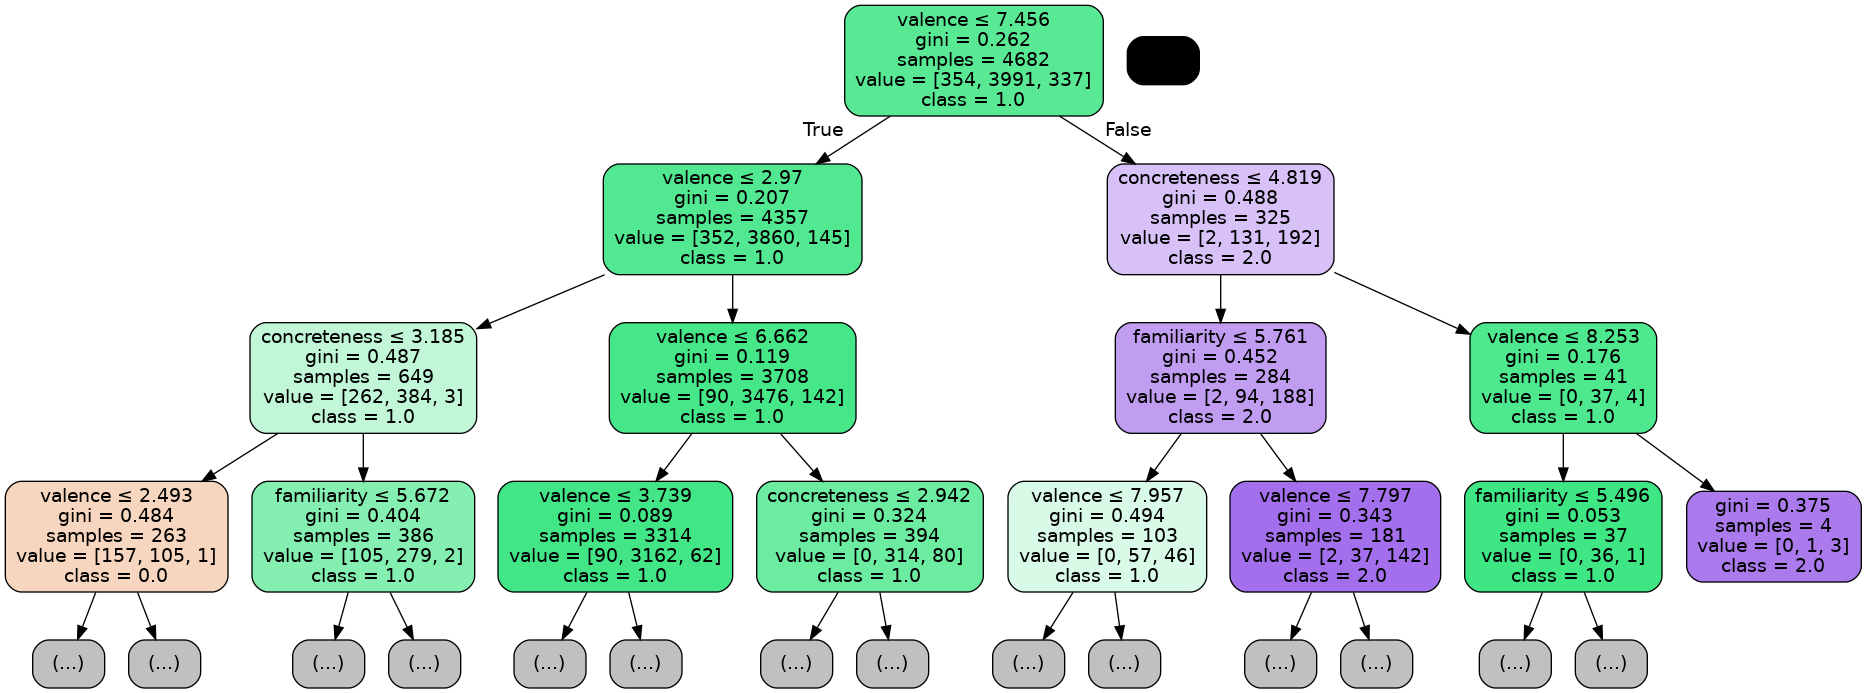

In [116]:
dot_data = tree.export_graphviz (grid_search.best_estimator_, out_file=None,
                                feature_names=attributes,
                                class_names=[str(v) for v in clf.classes_],
                                filled=True, rounded=True,
                                special_characters=True,
                                max_depth=3)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [117]:
y_train_pred = grid_search.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       0.76      0.41      0.53       248
         1.0       0.91      0.98      0.95      2793
         2.0       0.83      0.51      0.64       236

    accuracy                           0.90      3277
   macro avg       0.83      0.63      0.70      3277
weighted avg       0.90      0.90      0.89      3277



In [118]:
y_test_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.73      0.42      0.53       106
         1.0       0.92      0.98      0.95      1198
         2.0       0.85      0.60      0.71       101

    accuracy                           0.91      1405
   macro avg       0.83      0.67      0.73      1405
weighted avg       0.90      0.91      0.90      1405



In [119]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=17,
                       random_state=42)

# Decision Tree Classifier
### w/ oversampling

## SMOTE

In [120]:
imba_pipeline = make_pipeline(
    SMOTE(random_state=42, sampling_strategy='not majority'), 
    DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_split=11, 
                           min_samples_leaf=15, random_state=42))

In [121]:
twotwenty = list(range(2,20))
    
param_list = {
    'max_depth': [None] + [1,2,3,4,5],
    'min_samples_leaf': [2,3,4,5],
    'min_samples_split': list(range(10,20)),
             }
param_list = {'decisiontreeclassifier__' + key: param_list[key] for key in param_list}
grid_imba = GridSearchCV(imba_pipeline, param_grid=param_list, cv=5, scoring='f1_weighted',return_train_score=True)

In [122]:
grid_imba.fit(X_train, y_train)
grid_imba.best_params_

{'decisiontreeclassifier__max_depth': None,
 'decisiontreeclassifier__min_samples_leaf': 2,
 'decisiontreeclassifier__min_samples_split': 13}

In [123]:
y_test_pred = grid_imba.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.39      0.66      0.49       106
         1.0       0.94      0.82      0.88      1198
         2.0       0.41      0.71      0.52       101

    accuracy                           0.80      1405
   macro avg       0.58      0.73      0.63      1405
weighted avg       0.86      0.80      0.82      1405



In [124]:
grid_imba.best_estimator_[1]

DecisionTreeClassifier(min_samples_leaf=2, min_samples_split=13,
                       random_state=42)

## ADASYN

In [125]:
adasyn_pipeline =  make_pipeline(
    ADASYN(random_state=42, sampling_strategy='not majority'), 
    DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_split=11, 
                           min_samples_leaf=15, random_state=42))

In [126]:
param_list = {
    'max_depth': [None] + list(range(1,10)),
    'min_samples_leaf': list(range(2,10)),
    'min_samples_split': list(range(2,20)),
             }
param_list = {'decisiontreeclassifier__' + key: param_list[key] for key in param_list}
grid_adasyn = GridSearchCV(adasyn_pipeline, param_grid=param_list, cv=5, scoring='f1_weighted',return_train_score=True)

In [127]:
grid_adasyn.fit(X_train, y_train)
grid_adasyn.best_params_

{'decisiontreeclassifier__max_depth': None,
 'decisiontreeclassifier__min_samples_leaf': 2,
 'decisiontreeclassifier__min_samples_split': 5}

In [128]:
y_test_pred = grid_adasyn.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.36      0.64      0.46       106
         1.0       0.93      0.82      0.87      1198
         2.0       0.39      0.59      0.47       101

    accuracy                           0.79      1405
   macro avg       0.56      0.69      0.60      1405
weighted avg       0.85      0.79      0.81      1405



## RandomOverSampler

In [32]:
ros_pipeline =  make_pipeline(
    RandomOverSampler(random_state=42, sampling_strategy='not majority'), 
    DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_split=11, 
                           min_samples_leaf=15, random_state=42))

In [33]:
param_list = {
    'max_depth': [None] + list(range(1,10)),
    'min_samples_leaf': list(range(2,10)),
    'min_samples_split': list(range(2,20)),
             }
param_list = {'decisiontreeclassifier__' + key: param_list[key] for key in param_list}
grid_ros = GridSearchCV(ros_pipeline, param_grid=param_list, cv=5, scoring='f1_weighted',return_train_score=True)

In [34]:
grid_ros.fit(X_train, y_train)
grid_ros.best_params_

{'decisiontreeclassifier__max_depth': None,
 'decisiontreeclassifier__min_samples_leaf': 2,
 'decisiontreeclassifier__min_samples_split': 13}

In [35]:
y_test_pred = grid_ros.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.45      0.49      0.47       106
         1.0       0.92      0.91      0.91      1198
         2.0       0.53      0.55      0.54       101

    accuracy                           0.85      1405
   macro avg       0.63      0.65      0.64      1405
weighted avg       0.86      0.85      0.85      1405



## Undersampling with ClusterCentroids

In [36]:
cc_pipeline =  make_pipeline(
    ClusterCentroids(random_state=42), 
    DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_split=11, 
                           min_samples_leaf=15, random_state=42))

In [37]:
param_list = {
    'max_depth': [5],
    'min_samples_leaf': [7],
    'min_samples_split': [2],
             }
param_list = {'decisiontreeclassifier__' + key: param_list[key] for key in param_list}
grid_cc = GridSearchCV(cc_pipeline, param_grid=param_list, cv=5, scoring='f1_weighted',return_train_score=True)

In [38]:
grid_cc.fit(X_train, y_train)
grid_cc.best_params_

{'decisiontreeclassifier__max_depth': 5,
 'decisiontreeclassifier__min_samples_leaf': 7,
 'decisiontreeclassifier__min_samples_split': 2}

In [39]:
y_test_pred = grid_cc.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.33      0.81      0.47       106
         1.0       0.97      0.70      0.81      1198
         2.0       0.32      0.89      0.48       101

    accuracy                           0.72      1405
   macro avg       0.54      0.80      0.59      1405
weighted avg       0.87      0.72      0.76      1405



## Undersampling with CondensedNearestNeighbours

In [53]:
cnn_pipeline =  make_pipeline(
    CondensedNearestNeighbour(random_state=42, sampling_strategy='majority'), 
    DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_split=11, 
                           min_samples_leaf=15, random_state=42))

In [60]:
param_list = {
    'max_depth': [2],
    'min_samples_leaf': [5],
    'min_samples_split': [2],
             }
param_list = {'decisiontreeclassifier__' + key: param_list[key] for key in param_list}
grid_cnn = GridSearchCV(cnn_pipeline, param_grid=param_list, cv=5, scoring='f1_weighted',return_train_score=True)

In [63]:
grid_cnn.fit(X_train, y_train)
grid_cnn.best_params_

{'decisiontreeclassifier__max_depth': 2,
 'decisiontreeclassifier__min_samples_leaf': 5,
 'decisiontreeclassifier__min_samples_split': 2}

In [64]:
y_test_pred = grid_cnn.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.27      0.92      0.41       106
         1.0       0.96      0.72      0.83      1198
         2.0       0.53      0.70      0.61       101

    accuracy                           0.74      1405
   macro avg       0.59      0.78      0.61      1405
weighted avg       0.88      0.74      0.78      1405



In [65]:
X_cnn, y_cnn = grid_cnn.best_estimator_[0].fit_resample(X_train, y_train)

In [66]:
print(Counter(y_cnn))

Counter({1.0: 404, 0.0: 248, 2.0: 236})


In [67]:
print(Counter(y_train))

Counter({1.0: 2793, 0.0: 248, 2.0: 236})


# Decision Tree Classifier
## Comparing various random sampling methods

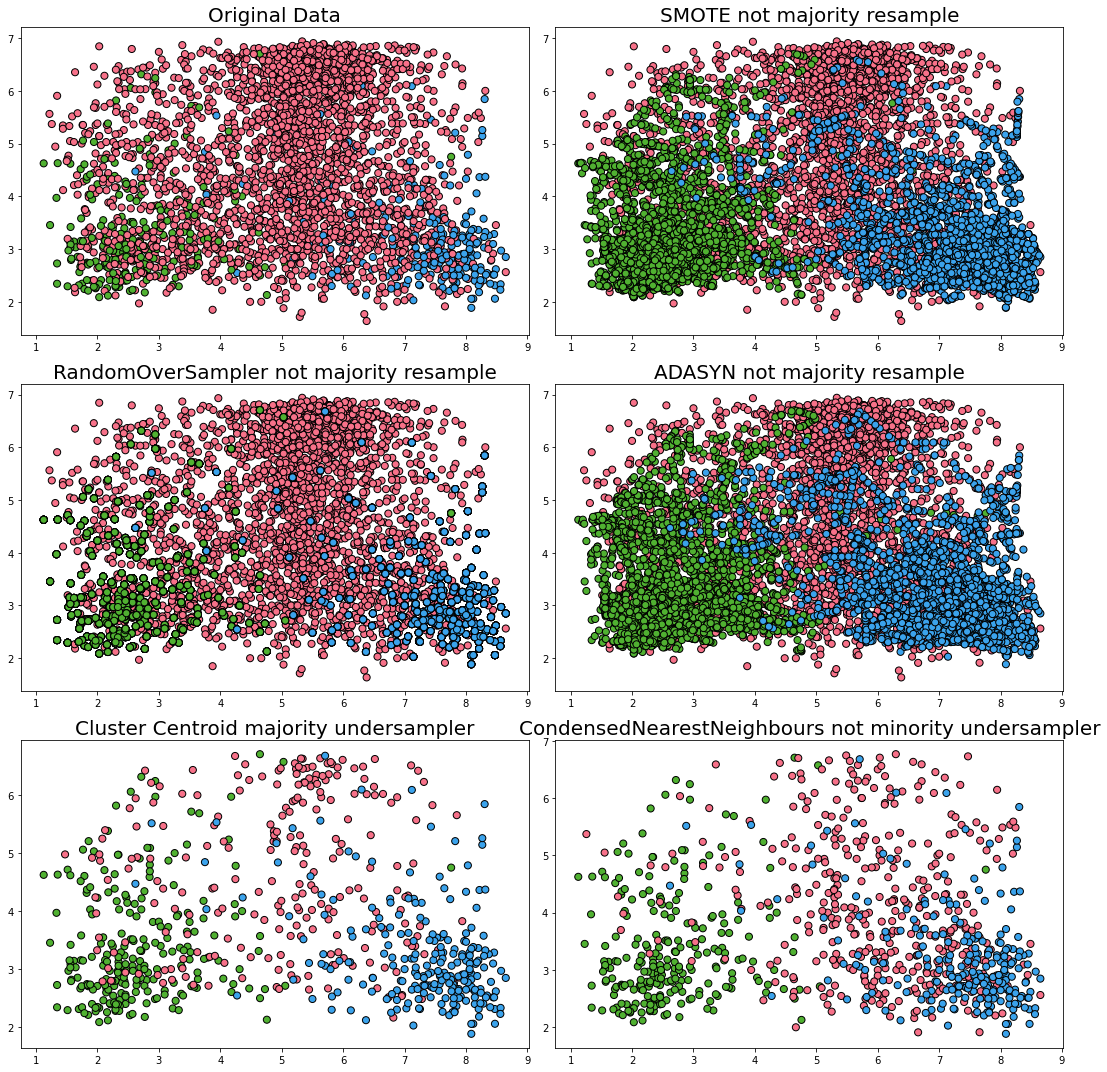

In [79]:
import seaborn as sns
fig, axs = plt.subplots(3, 2, figsize=(15,15))

# Get Unique continents
color_labels = y_train.unique()

# List of colors in the color palettes
rgb_values = sns.color_palette("husl", 3)

# Map continents to the colors
color_map = dict(zip(color_labels, rgb_values))

axs[0][0].scatter(X_train[:,1], X_train[:,3], c = y_train.map(color_map), marker =".", edgecolor='k', s=200)
axs[0][0].set_title("Original Data", fontsize=20)

X_smote, y_smote = grid_imba.best_estimator_[0].fit_resample(X_train, y_train)
axs[0][1].scatter(X_smote[:,1], X_smote[:,3], c = y_smote.map(color_map), marker =".", edgecolor='k', s=200)
axs[0][1].set_title("SMOTE not majority resample", fontsize=20)

X_ros, y_ros = grid_ros.best_estimator_[0].fit_resample(X_train, y_train)
axs[1][0].scatter(X_ros[:,1], X_ros[:,3], c = y_ros.map(color_map), marker =".", edgecolor='k', s=200)
axs[1][0].set_title("RandomOverSampler not majority resample", fontsize=20)

X_adasyn, y_adasyn = grid_adasyn.best_estimator_[0].fit_resample(X_train, y_train)
axs[1][1].scatter(X_adasyn[:,1], X_adasyn[:,3], c = y_adasyn.map(color_map), marker =".", edgecolor='k', s=200)
axs[1][1].set_title("ADASYN not majority resample", fontsize=20)

X_cc, y_cc = grid_cc.best_estimator_[0].fit_resample(X_train, y_train)
axs[2][0].scatter(X_cc[:,1], X_cc[:,3], c = y_cc.map(color_map), marker =".", edgecolor='k', s=200)
axs[2][0].set_title("Cluster Centroid majority undersampler", fontsize=20)

X_cnn, y_cnn = grid_cnn.best_estimator_[0].fit_resample(X_train, y_train)
axs[2][1].scatter(X_cnn[:,1], X_cnn[:,3], c = y_cnn.map(color_map), marker =".", edgecolor='k', s=200)
axs[2][1].set_title("CondensedNearestNeighbours not minority undersampler", fontsize=20)


fig.tight_layout()

plt.show()